# PA10, convolutional neural network

In this task you will need to train a convolutional neural networks, the architecture is the following:

1. Input, (n_batch, height, width, n_channels) - one channel grayscale image or three channel (RGB) image
2. Convolutional layer, 5x5 filters, 6 output channels, no padding, ReLU activation
3. Pooling layer, 2x2 max pooling, no padding
4. Convolutional layer, 5x5 filters, 16 output channels, no padding, ReLU activation
5. Pooling layer, 2x2 max pooling, no padding
6. Dense (fully connected layer), 120 hidden units, ReLU activation
7. Dense (fully connected layer), 84 hidden units, ReLU activation
8. Dense (fully connected layer), 10 hidden units (for 10 classes), no activation
9. Softmax 

## Part 1, Implementation

Implement the model using ```tf.layers``` and train it for MNIST dataset. You will need to use ```conv2d, max_pooling2d, dense``` layers for convolutional layer, max pooling and fully connected (dense) layer respectively. You may also use ```tf.contrib.layers.flatten``` in order to convert a feature map of size (n_batch,height,width,n_channels) to a batch of vectors of size (n_batch,height\*width\*n_channels).

Plot the loss function, and train/test set accuracy.

** Bonus **

After you trained the network on MNIST dataset, if you have time, you can also train to on CIFAR 10 dataset.
In order to read the dataset, you can use the function ```tf.keras.datasets.cifar10.load_data()``` (see the code below, the images now have different size). The description of the dataset is given on the following web-page (https://www.cs.toronto.edu/~kriz/cifar.html). Please note that it will take much more time to train the network, so it is very important to use an appropriate optimization method and choose the right batch size. You can stop earlier when the accuracy is reasonable if it takes too long to train the network.

## Part 2, computing the dimensions for the feature maps at each layer

Write a small comment on dimensions of the output for each conv and max pooling layer. 
For example:

1. Conv layer 1 takes an image of size 64x64, it has a filter of size 3x3 with padding 1, so the dimension of the output is 64+2\*1-(3-1) = 64. We have 32 feature maps in the output, so the size of the output is (n_batch,64,64,32).

2. Pooling layer does 2x2 max pooling for an image of size 64x64 with 32 feature maps, no padding is added. So, the size of the output is (n_batch,64/2,64/2,32)=(n_batch,64,64,32).

In [6]:
# import MNIST data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("Data/MNIST_data/", one_hot=False)

Extracting Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
def model(x):
    layer1 = tf.layers.conv2d(inputs=x, filters=6, kernel_size=(5, 5))  # we could also use activation parameter
    layer1 = tf.nn.relu(layer1)
    layer1 = tf.layers.max_pooling2d(inputs=layer1, pool_size=(2, 2), strides=(1, 1))
    
    layer2 = tf.layers.conv2d(inputs=layer1, filters=16, kernel_size=(5, 5))
    layer2 = tf.nn.relu(layer2)
    layer2 = tf.layers.max_pooling2d(inputs=layer2, pool_size=(2, 2), strides=(1, 1))
    
    flatten = tf.contrib.layers.flatten(layer2)
    
    dense1 = tf.layers.dense(flatten, 120, activation=tf.nn.relu)
    dense2 = tf.layers.dense(dense1, 84, activation=tf.nn.relu)
    dense3 = tf.layers.dense(dense2, 10)
    
    return dense3

In [8]:
n_classes = 10;

# this is needed to avoid clashes of names if there was a previous version of the same model
tf.reset_default_graph()

# two placeholders for the input and the target
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
y = tf.placeholder(tf.int64, shape=[None])

net = model(X)
p = tf.nn.softmax(net)

y_out_hot = tf.one_hot(y, n_classes)
# y_out_hot = tf.squeeze(y_out_hot, axis=1)

loss = tf.losses.softmax_cross_entropy(onehot_labels=y_out_hot, logits=net)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(p, 1), y), tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=.0001)
train = optimizer.minimize(loss)

In [9]:
# This code loads CIFAR 10 dataset (32x32 color images)

#import tensorflow as tf
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# mean and standard deviation for R,G,B channels respectively
# mean = {125.3, 123.0, 113.9}
# std = {63.0, 62.1, 66.7}

Epoch: 0, train_loss: 1.5537, train_acc: 0.5987, test_acc: 0.8528
Epoch: 1, train_loss: 0.4587, train_acc: 0.8845, test_acc: 0.9181
Epoch: 2, train_loss: 0.2723, train_acc: 0.9247, test_acc: 0.9403
Epoch: 3, train_loss: 0.2078, train_acc: 0.9415, test_acc: 0.9522
Epoch: 4, train_loss: 0.1686, train_acc: 0.9527, test_acc: 0.9587
Epoch: 5, train_loss: 0.1398, train_acc: 0.9604, test_acc: 0.9657
Epoch: 6, train_loss: 0.1201, train_acc: 0.9659, test_acc: 0.9705
Epoch: 7, train_loss: 0.1052, train_acc: 0.9694, test_acc: 0.9736
Epoch: 8, train_loss: 0.0935, train_acc: 0.9733, test_acc: 0.9764
Epoch: 9, train_loss: 0.0844, train_acc: 0.9757, test_acc: 0.9802


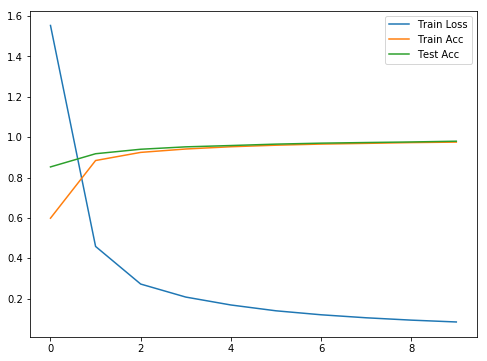

In [10]:
n_batch = 1000
n_epoch = 10
n_train = mnist.train.images.shape[0]

test_img = np.reshape(mnist.test.images, (10000, 28, 28, 1))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_loss_epoch = []
    train_acc_epoch = []
    test_acc_epoch = []
    
    for epoch in range(0, n_epoch):
        train_loss = 0
        train_acc = 0

        for i_batch in range(0, n_train // n_batch):
            batch_img, batch_target = mnist.train.next_batch(n_batch)
            batch_img_reshaped = np.reshape(batch_img, (n_batch, 28, 28, 1))
            
            [loss_value, acc_value] = sess.run([loss, accuracy], feed_dict={X: batch_img_reshaped , y: batch_target})
            train.run({X: batch_img_reshaped , y: batch_target})

            train_loss += loss_value
            train_acc += acc_value

        train_loss = train_loss / (n_train // n_batch)
        train_acc = train_acc / (n_train // n_batch)
        
        [test_acc] = sess.run([accuracy], feed_dict={X: test_img, y: mnist.test.labels})
        
        train_loss_epoch.append(train_loss)
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        print('Epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch, train_loss, train_acc, test_acc))
        
        
plt.figure(figsize=(8, 6))
plt.plot(train_loss_epoch, label='Train Loss')
plt.plot(train_acc_epoch, label='Train Acc')
plt.plot(test_acc_epoch, label='Test Acc')
plt.legend()

## Part 2, Compute the dimensions of the output for each layer.

In [11]:
# input (n_batch, 28, 28, 1)
# layer1 (n_batch, 23, 23, 6)
# layer2 (n_batch, 18, 18, 16)
# flatten (n_batch, 5184)
# danse1 (120,)
# dense2 (84,)
# out (10,)